<a href="https://colab.research.google.com/github/tulaycetin/Veri_Azaltma_Yontemleri/blob/main/%C3%96znitelik_Se%C3%A7imi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:

# Gerekli kütüphaneler
import kagglehub
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.svm import SVC



# **Veri Seti Yükleme ve Ön İnceleme**


In [23]:
# Hücre 2: Veri setini yükle ve ön inceleme
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print("Şekil:", df.shape)
print("\nEksik Değer Sayıları:\n", df.isnull().sum())
display(df.head())




Şekil: (891, 12)

Eksik Değer Sayıları:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S




# **IterativeImputer:**
**Tüm sayısal sütunlardaki eksik değerleri, diğer sütunlardan öğrenilen istatistikî modellerle (çok değişkenli regresyon) doldurur.**





In [24]:
# Hücre 3: Sayısal sütunlardaki eksikleri IterativeImputer ile doldur
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = IterativeImputer(random_state=42)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


# **One-Hot Encoding:**
**Kategorik bir özelliği (örn. Sex, Embarked) 0/1 değerleri alan yeni sütunlara dönüştürür. drop_first=True ile bir sütun atılır, böylece lineer bağımlılığın (dummy trap) önüne geçilir.**

In [25]:
# Hücre 4: One-hot encoding ile kategorikleri sayısala çevir
df = pd.get_dummies(df, drop_first=True)


In [26]:
# Hücre 5: Özellik ve hedef matrisini hazırla
y = df['Survived']
X = df.drop(columns=['Survived'])


# **StandardScaler:**
**Her sütunu ortalaması 0, standart sapması 1 olacak şekilde yeniden ölçeklendirir. SVM gibi mesafe-temelli modellerde önemlidir.**

In [27]:
# Hücre 6: Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# **Filtreleme (Filtering)**
Modelden bağımsız istatistiksel ölçümlere dayanır.

Varyans, korelasyon, bilgi kazancı gibi kriterlerle her bir özelliği sıralar ve belirli bir eşik değerinin üzerindekileri seçer.

Hesaplama hızlıdır ancak modele özgü etkileşimleri göz ardı edebili


---
SelectKBest (mutual_info_classif) Karşılıklı bilgi (mutual information) istatistiğine göre en yüksek bilgi değerine sahip ilk 20 özelliği seçer


In [28]:
# Hücre 7: Özellik seçme yöntemleri
# 7.1) SelectKBest (mutual_info)
kbest = SelectKBest(score_func=mutual_info_classif, k=20)
X_kbest = kbest.fit_transform(X_scaled, y)
kbest_cols = X.columns[kbest.get_support()]

# **Gömme (Embedded)**
Özellik seçimini model eğitimi sırasında otomatik yapan yöntemlerdir.

Düzenlilemeli (regularized) lineer modeller tipik örneklerdir:


* ** Lasso (L1 düzenleme):** Bazı katsayıları tam sıfıra çekerek seçimi gerçekleştirir.

*   **Ridge (L2 düzenleme): **Katsayıları sıfıra yaklaştırır, ancak tamamen sıfırlamaz.

*  **Elastic Net:** Lasso ile Ridge’in birleşimi; yüksek boyutlu ve çoklu ilişkilili veri setlerinde avantajlıdır .





---
LassoCV (embedded) L1 düzenlemeli regresyonla özellik ağırlıklarını küçültür; sıfır olmayan ağırlığa sahip sütunları alır.


In [29]:
# 7.2) LassoCV (embedded)
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso.fit(X_scaled, y)
mask_lasso = np.abs(lasso.coef_) > 1e-4
X_lasso = X_scaled[:, mask_lasso]
lasso_cols = X.columns[mask_lasso]


#**Model Değerlendirme Fonksiyonu**




**Accuracy:** Doğru sınıflandırılanların oranı.

**AUC (Area Under ROC Curve):** Sınıflandırıcının ayırt etme gücünü ölçen eğri altı alan.

**Confusion Matrix ve Classification Report:** Daha ayrıntılı metrikler (precision, recall, f1-score vs.).

In [30]:
# Hücre 8: Değerlendirme fonksiyonu
def evaluate_svm(X_feat, y, name):
    # Eğitim-test bölme
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_feat, y, test_size=0.2, random_state=42, stratify=y
    )
    # Model eğit ve tahmin
    model = SVC(kernel='rbf', C=0.1, gamma='auto',
                probability=True, class_weight='balanced', random_state=42)
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    pred = (proba >= 0.5).astype(int)

    # Metri̇kler
    acc = accuracy_score(y_te, pred)
    fpr, tpr, _ = roc_curve(y_te, proba)
    roc_auc = auc(fpr, tpr)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f} — AUC: {roc_auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_te, pred))
    print("Classification Report:\n", classification_report(y_te, pred))

    # ROC eğrisi
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC Curve — {name}')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend()
    plt.show()
    return acc, roc_auc


#**Yöntemlerin Karşılaştırılması**


=== Orijinal ===
Accuracy: 0.615 — AUC: 0.408
Confusion Matrix:
 [[110   0]
 [ 69   0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       110
         1.0       0.00      0.00      0.00        69

    accuracy                           0.61       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.61      0.47       179



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


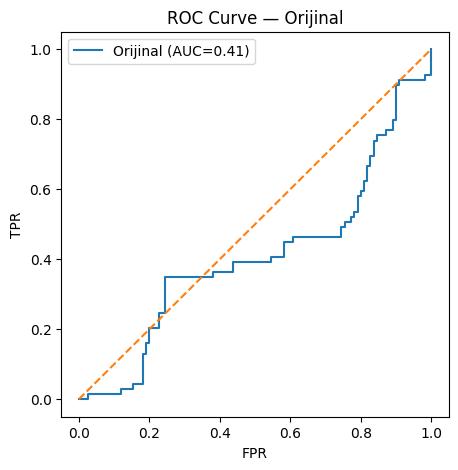


=== SelectKBest(20) ===
Accuracy: 0.754 — AUC: 0.826
Confusion Matrix:
 [[89 21]
 [23 46]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       110
         1.0       0.69      0.67      0.68        69

    accuracy                           0.75       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179



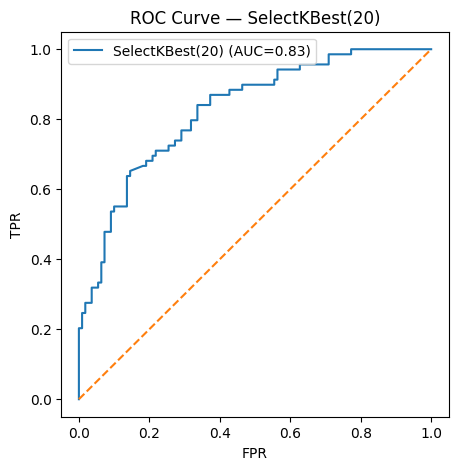


=== Lasso ===
Accuracy: 0.844 — AUC: 0.939
Confusion Matrix:
 [[92 18]
 [10 59]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       110
         1.0       0.77      0.86      0.81        69

    accuracy                           0.84       179
   macro avg       0.83      0.85      0.84       179
weighted avg       0.85      0.84      0.84       179



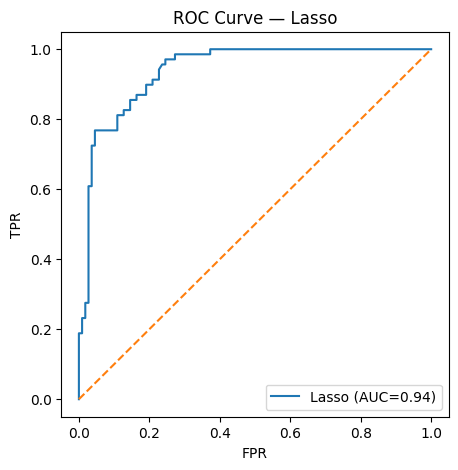

,Accuracy,AUC
Orijinal,0.614525,0.408300
SelectKBest(20),0.754190,0.825823
Lasso,0.843575,0.938933


In [31]:
# Hücre 9: Tüm yöntemleri değerlendir ve sonuçları karşılaştır
methods = {
    'Orijinal':          X_scaled,
    'SelectKBest(20)':   X_kbest,
    'Lasso':             X_lasso,

}

results = {}
for name, X_m in methods.items():
    results[name] = evaluate_svm(X_m, y, name)

# Hücre 10: Sonuçları tablo olarak göster
res_df = pd.DataFrame(results, index=['Accuracy', 'AUC']).T
display(res_df)
